### **Experiment #1 - Launder Monitoring**

This is.

<br>

**Step 1. Load the external dependencies.**

In [1]:
# import external modules
import cv2 #opencv
import numpy as np #numpy
import matplotlib.pyplot as plt #matplotlib

In [2]:
# define helper function for displaying results
def display(img,cmap='gray'):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img,cmap='gray')

<br>

**Step 2. Load the launder image and convert to RGB.**

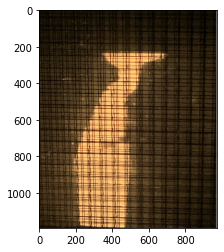

In [3]:
# load the launder test image
flow_orig = cv2.imread('DATA/test1_original.png')

# convert from BGR to RGB
flow_orig = cv2.cvtColor(flow_orig,cv2.COLOR_BGR2RGB)

# display launder image using helper function
display(flow_orig)

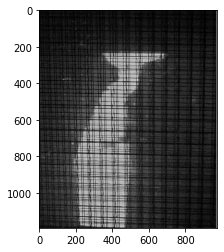

In [10]:
# convert from BGR to gray
flow_gray = cv2.cvtColor(flow_orig,cv2.COLOR_BGR2GRAY)

# display the grayscale image
display(flow_gray)

<br>

**Step 3. Load the target polgyon and convert to grayscale.**

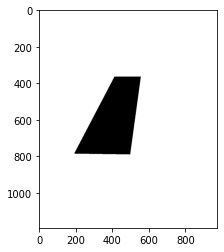

In [5]:
# load target polygon
target = cv2.imread('DATA/test1_target.png')

# convert the polygon from BGR to grayscale
target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY) 

# show the target polygon
display(target)

<br>

**Step 4. Process launder image.**

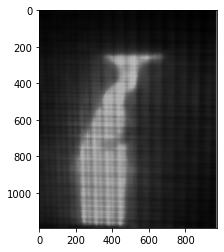

In [6]:
# define kernel size (how much to blur the image) - use 50 for test mage 1; 5 for test 2 and 3, given their resolution difference)
#kernel_size = 50

# blur the launder image
flow_blur = cv2.medianBlur(flow_gray,49) #work best with test 1 -50

# display the blurred image
display(flow_blur)

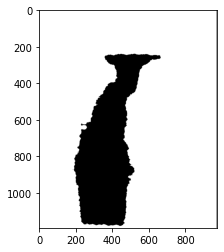

In [8]:
# apply binary thresholding to find contour of molten metal shape
ret, flow_thresh = cv2.threshold(flow_blur,160,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# display the thresholded image
display(flow_thresh)

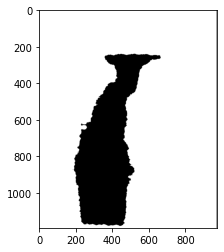

In [9]:
# remove noise using morphological transformation

# define kernel size
kernel = np.ones((1,1),np.uint8)

# apply transformation
flow_noise = cv2.morphologyEx(flow_thresh,cv2.MORPH_OPEN, kernel, iterations=10)

# display transformed image
display(flow_noise)

<br>

**Step 5. Blend the actual and the target to find the overlap (i.e. the area where there is potential buildup).**

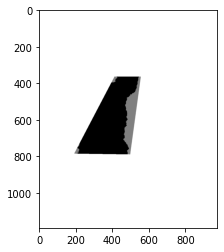

In [15]:
# blend the actual and the target
overlap = cv2.addWeighted(src1=target,alpha=1,src2=flow_noise,beta=0.5,gamma=0)

# make a backup of the overlap image
orig_overlap = overlap.copy()

# display the overlap image
display(orig_overlap)

<br>

**Step 6. Calculate the percent buildup.**

In [23]:
# count of black, grey, white pixels in the overlap image
cnt_black = np.count_nonzero(overlap == 0) # number of black pixels; represents the size of the molten metal
cnt_grey = np.count_nonzero(overlap == 128) # number of grey pixels; represents the size of potential buildup
cnt_white = np.count_nonzero(overlap == 255) # number of white pixels; represents the size of the whitespace around the image

# print the # of pixels
print(f"Black pixels: {cnt_black}")
print(f"Grey pixels: {cnt_grey}")
print(f"White pixels: {cnt_white}")

Black pixels: 78715
Grey pixels: 17047
White pixels: 1065246


In [42]:
# calculate total number of pixels
cnt_total = cnt_black + cnt_grey

# calculate the percent buildup
perc_buildup = round(cnt_grey / cnt_total * 100,2)

print(f"Percent Buildup: {perc_buildup}")

Percent Buildup: 17.8


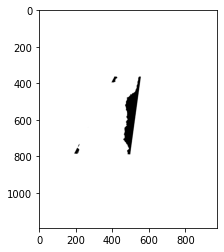

In [25]:
# prepare the buildup image

# replace all blacks pixels with white
overlap[overlap == 0] = 255

# display the buildup image
display(overlap)


<br>

**Step 7. Compare buildup to treshold for alerting.**

In [29]:
# set threshold
t = 10

# check if % buildup greater than threshold; if so, send alert
if (perc_buildup > t):
    print(f"There is a {perc_buildup}% buildup on the launder. Remain alert and prepare to make necessary adjustments.")

There is a 17.8% buildup on the launder. Remain alert and prepare to make necessary adjustments.


<br>

**Optional: Step 8. Overlay overflow ontop of original image.**

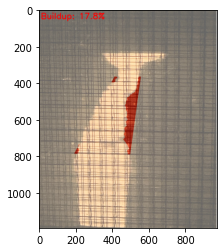

In [35]:
# convert overlap image from grayscale to RGB
overlap_red = cv2.cvtColor(overlap,cv2.COLOR_GRAY2RGB)

# find all grey (128,128,128) values in overlap image and change to red (255,0,0) for visualization purposes
overlap_red[np.where((overlap_red==[128, 128, 128]).all(axis=2))] = [255,0,0]

# blend the overlap and original images
result = cv2.addWeighted(src1=flow_orig,alpha=0.6,src2=overlap_red,beta=0.4,gamma=0)

# write launder buildup % to top left corner of the image
cv2.putText(result, f"Buildup: {perc_buildup}%", (10, 48), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 3)

# display the overlaid image
display(result)

<br>

**Optional: Step 9. Generate image containing all processing steps.**

The following code creates a 2 x 4 image plot, with each image in the plot showing a key step of the launder image processing code. The resulting plots were used in the accompanying report submission. Note that there are  

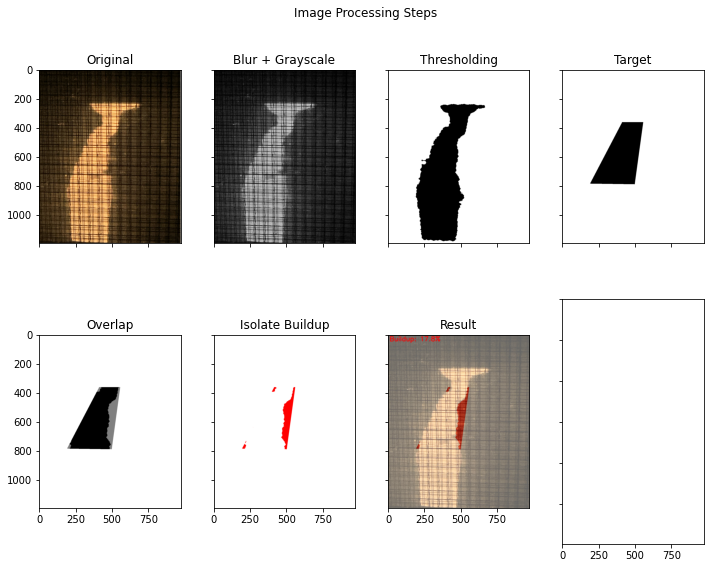

In [41]:
# define the plot size
rows = 2
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(10,8))

# label the plot
fig.suptitle('Image Processing Steps')

# set the spacing of the plot
fig.tight_layout(h_pad=1)

# original image
axs[0,0].imshow(flow_orig) #top left
axs[0,0].title.set_text('Original')

# greyscale + blurred image
axs[0,1].imshow(flow_gray, cmap="gray")
axs[0,1].title.set_text('Blur + Grayscale')

# thresholding image
axs[0,2].imshow(flow_noise, cmap="gray")
axs[0,2].title.set_text('Thresholding')

# target polygon image
axs[0,3].imshow(target, cmap="gray")
axs[0,3].title.set_text('Target')

# overlap image
axs[1,0].imshow(orig_overlap, cmap="gray")
axs[1,0].title.set_text('Overlap')

# buildup image
axs[1,1].imshow(overlap_red, cmap="gray")
axs[1,1].title.set_text('Isolate Buildup')

# result image
axs[1,2].imshow(result, cmap="gray")
axs[1,2].title.set_text("Result")

# remove the 8th subplot as it is unused
fig.delaxes(axs[1,3])

# show the processing steps image
display(